06-combine-two-mechanisms.ipynb
======================

In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.
* Make code modular (create a function for plotting).

## Load packages and read tables.

In [ ]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [51]:
# Read a summary table of the victimisation-based mechanism.
vic_data = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/vic_tab.parquet")
vic_data.registerTempTable("vic_data")

# Read a summary table of the observation-based mechanism.
obs_data = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/obs_tab.parquet")
obs_data.registerTempTable("obs_data")

In [ ]:
# Collect the transitions that happened within seven days after observing or being killed by cheating.
vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

In [52]:
# Show the first few rows of each dataset.
vic_tab.show()
obs_tab.show()

obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.53db3bd71...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.476ee023d...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...

## 1. Merge two tables.

In [53]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.090ca369b...|2019-03-02|
|account.272b33c63...|2019-03-02|
|account.da692c372...|2019-03-02|
|account.53db3bd71...|2019-03-02|
|account.ab15ceb31...|2019-03-02|
|account.8d69e3520...|2019-03-02|
|account.11dbd81ee...|2019-03-02|
|account.da1a6fa0b...|2019-03-02|
|account.27478c512...|2019-03-02|
|account.e493e8036...|2019-03-02|
+--------------------+----------+
only showing top 10 rows



In [54]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_obs IS NULL THEN 0 ELSE total_obs END AS total_obs, 
                            CASE WHEN total_sev_dam IS NULL THEN 0 ELSE total_sev_dam END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.090ca369b...|2019-03-02|        3|      0|        0|      0|
|account.272b33c63...|2019-03-02|       11|      0|        1|      0|
|account.da692c372...|2019-03-02|        8|      1|        0|      0|
|account.53db3bd71...|2019-03-02|        1|      0|        1|      0|
|account.ab15ceb31...|2019-03-02|        1|      0|        0|      0|
|account.8d69e3520...|2019-03-02|       59|     21|        0|      0|
|account.11dbd81ee...|2019-03-02|        9|      1|        0|      0|
|account.da1a6fa0b...|2019-03-02|       35|     17|        0|      0|
|account.27478c512...|2019-03-02|       50|     16|        0|      0|
|account.e493e8036...|2019-03-02|       23|      0|        2|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

## 2. Plot the distribution of experiences and observations.

In [55]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
print(pairs_tab)

    total_obs  total_exp  freq
0           1          0     3
1           1          1     1
2           2          0     2
3           2          1     1
4           3          0     8
5           3          1     1
6           4          0     2
7           6          0     4
8           7          0     1
9           8          0     3
10          8          3     1
11          9          0     1
12         10          1     1
13         11          1     2
14         12          1     1
15         13          0     1
16         14          0     1
17         15          0     1
18         16          0     1
19         17          0     1
20         18          0     1
21         18          1     2
22         20          0     1
23         22          0     1
24         23          0     1
25         23          2     1
26         26          0     2
27         31          1     1
28         34          0     1
29         35          0     1
30         36          0     1
31      

In [56]:
sev_pairs_tab = merged_tab.groupby(['sev_obs', 'sev_exp']).size().reset_index(name="freq")
print(sev_pairs_tab)

    sev_obs  sev_exp  freq
0         0        0    22
1         1        0     3
2         2        0     2
3         3        0     5
4         5        1     1
5         6        1     1
6         7        0     3
7         8        0     1
8         9        0     2
9         9        1     1
10       10        0     1
11       11        0     3
12       13        1     1
13       14        0     1
14       15        0     1
15       16        0     2
16       17        0     1
17       21        0     1
18       23        0     1
19       48        0     1


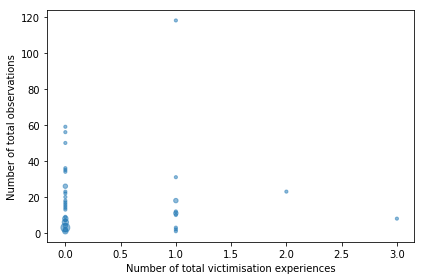

In [11]:
# Create a scatter plot.
fig = plt.scatter(pairs_tab['total_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('Number of total victimisation experiences')
plt.ylabel('Number of total observations')
plt.tight_layout()
plt.show()

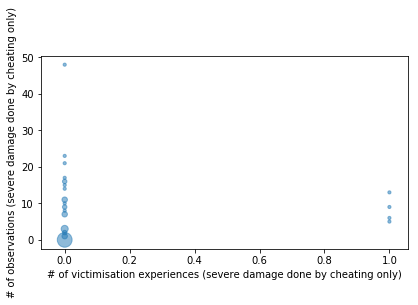

In [12]:
# Create a scatter plot.
fig = plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['sev_obs'], 
                  s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('# of victimisation experiences (severe damage done by cheating only)')
plt.ylabel('# of observations (severe damage done by cheating only)')
plt.tight_layout()
plt.show()

## 3. Create a merged data table for randomised networks.

In [45]:
# Read a summary table of the victimisation-based mechanism.
vic_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/rand-net/vic_tab_3.parquet")
vic_tab.registerTempTable("vic_tab")

# Read a summary table of the observation-based mechanism.
obs_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/rand-net/obs_tab_3.parquet")
obs_tab.registerTempTable("obs_tab")

# Show the first few rows of each dataset.
vic_tab.show()
obs_tab.show()

obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...|2019-03-02|2019-03-01|     1|        2|            0|           1|
|account.70eb95960...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.c3d862798...

In [46]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.090ca369b...|2019-03-02|
|account.272b33c63...|2019-03-02|
|account.da692c372...|2019-03-02|
|account.8d69e3520...|2019-03-02|
|account.11dbd81ee...|2019-03-02|
|account.da1a6fa0b...|2019-03-02|
|account.27478c512...|2019-03-02|
|account.e493e8036...|2019-03-02|
|account.71aea180f...|2019-03-02|
|account.ab15ceb31...|2019-03-02|
+--------------------+----------+
only showing top 10 rows



In [47]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_obs IS NULL THEN 0 ELSE total_obs END AS total_obs, 
                            CASE WHEN total_sev_dam IS NULL THEN 0 ELSE total_sev_dam END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.090ca369b...|2019-03-02|        3|      0|        0|      0|
|account.272b33c63...|2019-03-02|        9|      0|        1|      0|
|account.da692c372...|2019-03-02|        8|      1|        0|      0|
|account.8d69e3520...|2019-03-02|       41|     20|        0|      0|
|account.11dbd81ee...|2019-03-02|        9|      1|        0|      0|
|account.da1a6fa0b...|2019-03-02|       17|      3|        0|      0|
|account.27478c512...|2019-03-02|       31|     10|        0|      0|
|account.e493e8036...|2019-03-02|       23|      0|        2|      0|
|account.71aea180f...|2019-03-02|        3|      3|        0|      0|
|account.ab15ceb31...|2019-03-02|        1|      0|        0|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

In [48]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
print(pairs_tab)

    total_obs  total_exp  freq
0           1          0     2
1           1          1     1
2           2          0     2
3           3          0     7
4           4          0     4
5           5          0     1
6           6          0     2
7           7          0     1
8           8          0     2
9           9          0     2
10          9          1     1
11         10          1     1
12         10          2     1
13         11          0     1
14         13          0     1
15         15          0     1
16         16          0     1
17         17          0     2
18         17          1     1
19         18          0     3
20         19          0     2
21         19          1     1
22         20          0     1
23         21          0     1
24         21          1     1
25         23          2     1
26         27          1     1
27         29          0     1
28         31          0     1
29         32          0     1
30         34          0     1
31      

In [49]:
sev_pairs_tab = merged_tab.groupby(['sev_obs', 'sev_exp']).size().reset_index(name="freq")
print(sev_pairs_tab)

    sev_obs  sev_exp  freq
0         0        0    17
1         1        0     3
2         2        0     2
3         3        0     9
4         4        0     2
5         5        0     1
6         5        1     1
7         7        0     2
8         9        0     2
9         9        1     1
10       10        0     1
11       11        0     1
12       12        0     2
13       14        1     1
14       15        0     1
15       17        0     1
16       19        0     1
17       20        0     2
18       23        0     1
19       60        0     1


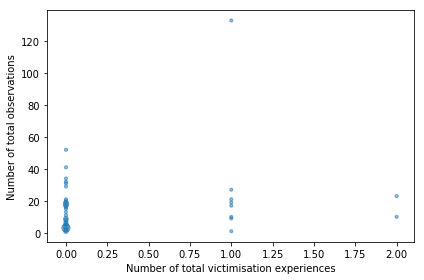

In [25]:
# Create a scatter plot.
fig = plt.scatter(pairs_tab['total_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('Number of total victimisation experiences')
plt.ylabel('Number of total observations')
plt.tight_layout()
plt.show()

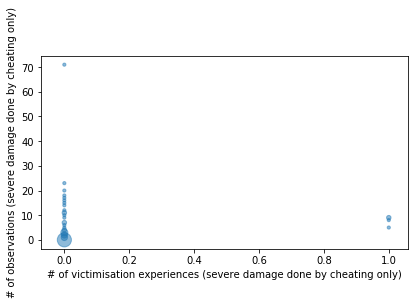

In [29]:
# Create a scatter plot.
fig = plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['sev_obs'], 
                  s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('# of victimisation experiences (severe damage done by cheating only)')
plt.ylabel('# of observations (severe damage done by cheating only)')
plt.tight_layout()
plt.show()

## 4. Create a heatmap.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd

In [15]:
# Test a heatmap using the small dataset (with the results from three randomised networks and one empirical network).
test_dat = pd.read_csv("test_tab.csv")

test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
print(test_dat)

    total_obs  total_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3
0           1          0       3.0          3.0          2.0          2.0
1           2          0       2.0          2.0          2.0          2.0
2           3          0       8.0          7.0          6.0          7.0
3           4          0       2.0          2.0          1.0          4.0
4           5          0       0.0          3.0          2.0          1.0
5           6          0       4.0          2.0          4.0          2.0
6           7          0       1.0          2.0          1.0          1.0
7           8          0       3.0          2.0          2.0          2.0
8           9          0       1.0          1.0          4.0          2.0
9          10          0       0.0          3.0          1.0          0.0
10         11          0       0.0          1.0          2.0          1.0
11         12          0       0.0          1.0          0.0          0.0
12         13          0       1.0    

In [16]:
bins = [-np.inf, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
col_names = ['emp_freq','rand_freq_1', 'rand_freq_2', 'rand_freq_3']

res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs, bins, 
                                                   labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
                                                   include_lowest =True)])[col_names].sum().reset_index()
res.total_obs = res.total_obs.astype(int)
res = res.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
res = res.fillna(0)
print(res)

    total_exp  total_obs  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3
0           0          1      15.0         17.0         13.0         16.0
1           0          2       9.0         10.0         12.0          7.0
2           0          3       3.0          4.0          5.0          3.0
3           0          4       4.0          3.0          5.0          9.0
4           0          5       2.0          5.0          1.0          1.0
5           0          6       2.0          1.0          1.0          1.0
6           0          7       2.0          1.0          1.0          3.0
7           0          8       1.0          1.0          0.0          0.0
8           0          9       0.0          0.0          1.0          1.0
9           0         10       1.0          1.0          0.0          0.0
10          0         11       2.0          1.0          1.0          1.0
11          1          1       3.0          2.0          3.0          1.0
12          1          2       1.0    

In [18]:
res['rand_mean'] = res.iloc[:, 3:].mean(axis=1)
res['rand_std'] = res.iloc[:, 3:].std(axis=1)

res['observed_stat'] = (res['emp_freq'] - res['rand_mean']) / res['rand_std']
res = res.round({"rand_mean":2, "rand_std":2, "observed_stat":2})
print(res)

    total_exp  total_obs  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
0           0          1      15.0         17.0         13.0         16.0   
1           0          2       9.0         10.0         12.0          7.0   
2           0          3       3.0          4.0          5.0          3.0   
3           0          4       4.0          3.0          5.0          9.0   
4           0          5       2.0          5.0          1.0          1.0   
5           0          6       2.0          1.0          1.0          1.0   
6           0          7       2.0          1.0          1.0          3.0   
7           0          8       1.0          1.0          0.0          0.0   
8           0          9       0.0          0.0          1.0          1.0   
9           0         10       1.0          1.0          0.0          0.0   
10          0         11       2.0          1.0          1.0          1.0   
11          1          1       3.0          2.0          3.0          1.0   

In [19]:
res = res.replace([np.inf, -np.inf], np.nan)
print(res)

    total_exp  total_obs  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
0           0          1      15.0         17.0         13.0         16.0   
1           0          2       9.0         10.0         12.0          7.0   
2           0          3       3.0          4.0          5.0          3.0   
3           0          4       4.0          3.0          5.0          9.0   
4           0          5       2.0          5.0          1.0          1.0   
5           0          6       2.0          1.0          1.0          1.0   
6           0          7       2.0          1.0          1.0          3.0   
7           0          8       1.0          1.0          0.0          0.0   
8           0          9       0.0          0.0          1.0          1.0   
9           0         10       1.0          1.0          0.0          0.0   
10          0         11       2.0          1.0          1.0          1.0   
11          1          1       3.0          2.0          3.0          1.0   

In [20]:
# piv = pd.pivot_table(copied_dt, values="observed_stat",index=["total_exp"], columns=["total_obs"], fill_value=0)

piv = pd.pivot_table(res, values="observed_stat",index=["total_exp"], columns=["total_obs"])
print(piv)

total_obs    1     2     3     4     5     6     7     8     9     10
total_exp                                                            
0         -0.20 -0.32 -1.22 -0.67 -0.18   NaN  0.35  1.41 -1.41  1.41
1          1.22 -1.41  1.07 -0.71 -1.41 -0.71   NaN   NaN   NaN   NaN
2           NaN -0.71 -0.71   NaN  1.41   NaN   NaN   NaN   NaN   NaN
3           NaN  1.41 -0.71   NaN   NaN   NaN   NaN   NaN   NaN   NaN


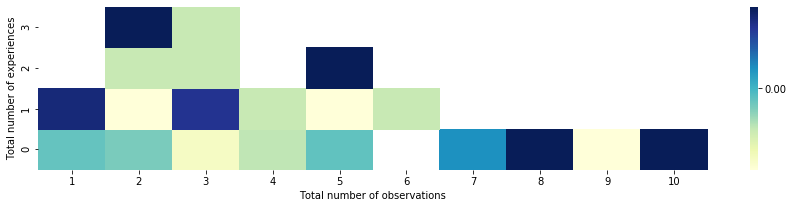

In [22]:
# Plot a heatmap.
plt.figure(figsize=(15, 3))
ax = sns.heatmap(piv, cmap="YlGnBu", cbar_kws=dict(ticks=[-1.96, 0, 1.96]))
ax.invert_yaxis()
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')
plt.show()

In [25]:
# Create a heatmap using killings and observations with high level of harm.
test_sev_dat = pd.read_csv("test_sev_tab.csv")

test_sev_dat = test_sev_dat.sort_values(['sev_exp', 'sev_obs']).reset_index(drop=True)
print(test_sev_dat)

    sev_obs  sev_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3
0         0        0      22.0         20.0         24.0         17.0
1         1        0       3.0          4.0          3.0          3.0
2         2        0       2.0          4.0          1.0          2.0
3         3        0       5.0          5.0          6.0          9.0
4         4        0       0.0          2.0          0.0          2.0
5         5        0       0.0          1.0          2.0          1.0
6         6        0       0.0          1.0          0.0          0.0
7         7        0       3.0          2.0          3.0          2.0
8         8        0       1.0          0.0          2.0          0.0
9         9        0       2.0          1.0          2.0          2.0
10       10        0       1.0          1.0          0.0          1.0
11       11        0       3.0          2.0          2.0          1.0
12       12        0       0.0          1.0          0.0          2.0
13       13        0

In [26]:
bins = [-np.inf, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
col_names = ['emp_freq','rand_freq_1', 'rand_freq_2', 'rand_freq_3']

res = test_sev_dat.groupby([test_sev_dat.sev_exp, pd.cut(test_sev_dat.sev_obs, bins, 
                                                         labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
                                                         include_lowest =True)])[col_names].sum().reset_index()
res.sev_obs = res.sev_obs.astype(int)
res = res.sort_values(['sev_exp', 'sev_obs']).reset_index(drop=True)
res = res.fillna(0)

res['rand_mean'] = res.iloc[:, 3:].mean(axis=1)
res['rand_std'] = res.iloc[:, 3:].std(axis=1)

res['observed_stat'] = (res['emp_freq'] - res['rand_mean']) / res['rand_std']
res = res.round({"rand_mean":2, "rand_std":2, "observed_stat":2})

res = res.replace([np.inf, -np.inf], np.nan)
print(res)

    sev_exp  sev_obs  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
0         0        1      32.0         36.0         36.0         34.0   
1         0        2       7.0          5.0          7.0          5.0   
2         0        3       5.0          5.0          5.0          4.0   
3         0        4       3.0          4.0          3.0          4.0   
4         0        5       2.0          1.0          0.0          1.0   
5         0        6       0.0          0.0          0.0          0.0   
6         0        7       0.0          0.0          0.0          0.0   
7         0        8       0.0          0.0          0.0          0.0   
8         0        9       0.0          0.0          0.0          0.0   
9         0       10       1.0          0.0          0.0          0.0   
10        0       11       0.0          1.0          1.0          1.0   
11        1        1       1.0          1.0          1.0          1.0   
12        1        2       2.0          3.0        

In [27]:
piv = pd.pivot_table(res, values="observed_stat",index=["sev_exp"], columns=["sev_obs"])
print(piv)

sev_obs     1     2     3     4     5
sev_exp                              
0       -3.54  1.41  0.71 -1.41  2.83
1         NaN  0.35  1.41   NaN   NaN


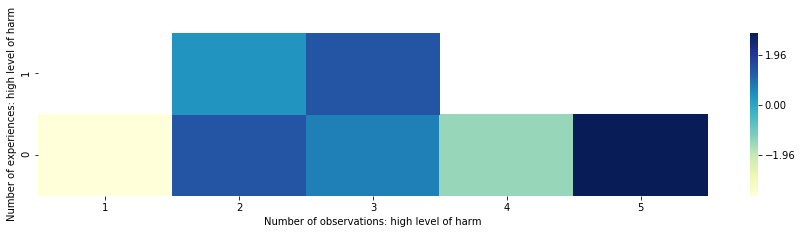

In [28]:
plt.figure(figsize=(15, 3))
ax = sns.heatmap(piv, cmap="YlGnBu", cbar_kws=dict(ticks=[-1.96, 0, 1.96]))
ax.invert_yaxis()
plt.xlabel('Number of observations: high level of harm')
plt.ylabel('Number of experiences: high level of harm')
plt.show()